## MaNGA and SGA Crossmatch

In [1]:
import os
from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table, QTable, SortedArray
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy import constants
from desispec.spectra import stack as specstack
from desispec.io import read_spectra, write_spectra

import numpy as np
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)
mpl.rc('axes', titlesize='small')

## Read in MaNGA data

~~MaNGA data obtained from the following URL and imported as a .txt file: http://www.pas.rochester.edu/~kdouglass/Research/data/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_noWords_v5.txt~~

**Note:** Now matching directly from the MaNGA drpall file.

In [3]:
MANGA_FOLDER = '/project/projectdirs/sdss/data/sdss/dr17/manga/spectro/'

#MaNGA_data = Table.read('MaNGA.txt', format='ascii.commented_header')
MaNGA_data = Table.read(MANGA_FOLDER+'redux/v3_1_1/drpall-v3_1_1.fits', 'MANGA')

print(len(MaNGA_data))
MaNGA_data[:5]

11273


plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7]
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10001,12701,10001-12701,1-48157,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,133.371090612,57.5984251446,159.27921887,38.8381829181,133.37109,57.598425,0.0545561,9,8100.81,0,20.0835,41.292,ma079,22,3,9114,134.41357,57.604214,1.10715,1.15321,1.21404,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.69906,2.64546,2.59645,2.54039,2080,0,0,1,plateTargets-1.par,6013,J085329.03+573554.9,127,127,0,0.0392074,0.0193562,0.0264775,0.0386959,0.0429176,0.0193562,0.0264775,0.748562,-999.0,0.665321,0.705378,1.08789,1.19925,-999.0,0.66562,0.705713,203,1350,6,v1_0_1,51226,-999,0.0392074,0.0395926,-16.2982 .. -19.5112,-16.2321 .. -19.5522,275.541 .. 452.944,3068010000.0,2685340000.0,0.417013,69.2463,0.448783 .. 0.0800664,5.16633,3.63987,12.7947 .. 413.049,3.26768 .. 0.000422625,13.8306 .. 425.941,3.03694 .. 0.00496838,0.335333,0.741845,68.2584,5.29184,14.8124 .. 412.19,2.50888 .. 0.0150605
10001,12702,10001-12702,1-48188,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,133.685669869,57.4802503218,159.390126911,39.0253440844,133.68567,57.48025,0.0492053,9,8100.81,0,20.0835,41.292,ma078,25,3,9114,134.41357,57.604214,1.10569,1.15089,1.21106,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.72072,2.66314,2.64652,2.61686,2080,0,0,1,plateTargets-1.par,6013,J085444.56+572848.8,127,217,0,0.0408108,0.0193227,0.0264533,0.0386469,0.042869,0.0188554,0.0266531,0.794785,-999.0,0.651037,0.681893,1.04947,1.13205,-999.0,0.631507,0.660498,35,3600,5,v1_0_1,51261,-999,0.0408108,0.0411932,-15.9069 .. -19.6569,-16.127 .. -19.5493,206.664 .. 49.3569,5341650000.0,4642460000.0,0.598115,12.5169,0.405779 .. 0.072394,7.01311,6.11281,12.4553 .. 396.399,2.27628 .. 0.000372112,12.4406 .. 390.985,2.3517 .. 0.000398299,0.508217,1.44272,12.3759,8.34906,10.1128 .. 432.884,3.38905 .. 0.00964978
10001,12703,10001-12703,1-55648,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,136.017159969,57.0923291779,159.56459216,40.3368076472,136.01716,57.092329,0.0258626,9,8100.81,0,19.9086,40.7596,ma077,31,3,9114,134.41357,57.604214,1.09975,1.13824,1.19323,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.7262,2.61384,2.56576,2.53132,2080,0,

## Read in SGA data

In [4]:
SGA_filename = '/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits'

hdu = fits.open(SGA_filename)
SGA = QTable(hdu[1].data)
hdu.close()

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,2025p070,202.5

In [15]:
SGA[SGA['SGA_ID'] == 125394]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
125394,SGA-2020 125394,PGC3093006,3093006,44.7465675,-7.2954658,E?,0.0,0.3723917,0.9397233,0.029651847,23.47048,16.987,False,LEDA-20181114,42692,PGC3093006,1,True,44.7465675,-7.2954658,0.3723917,0446m072,44.74649160008817,-7.295433143799257,0.46600676,SB26,12.732992,0.9194259,44.7464248182921,-7.295372103559361,11.742011,2.838639,2.6363032,2.5810108,4.7029157,5.6601233,6.675086,7.747926,8.8853035,10.088158,11.328175,12.622455,13.980203,16.81967,15.98794,15.383608,16.721033,15.89279,15.290031,16.647655,15.8218775,15.220558,16.5941,15.770171,15.169677,16.555273,15.732966,15.133439,16.52584,15.705055,15.106689,16.503696,15.683982,15.085867,16.487417,15.669551,15.071914,16.474672,15.658789,15.061761,0.0058384757,0.01107265,0.009003435,0.010540109,0.015754245,0.03294939,0.041437663,0.06545248,0.09164965,0.005349443,0.0063605052,0.007922485,0.0049340692,0.0058695413,0.0073042656,0.0046522436,0.0055304044,0.0068785227,0.0044570845,0.0052919667,0.006579054,0.0043167924,0.0051243952,0.0063732783,0.004215384,0.0050591803,0.006310372,0.004141626,0.004913752,0.0061165956,0.0040920055,0.0049088984,0.0061260057,0.004053726,0.0048122127,0.0059967455,16.421995,0.43066376,0.27725378,2.254403,0.03233932,15.6177635,0.31874177,0.3205609,2.5500128,0.0385135,15.0228,0.3091689,0.31593883,2.5802062,0.037289962,0


## Match SGA-2020 catalog with MaNGA data

In [5]:
SGA_coords = SkyCoord(ra=SGA['RA']*u.degree, dec=SGA['DEC']*u.degree)
#MaNGA_coords = SkyCoord(ra=MaNGA_data['NSA_RA']*u.degree, dec=MaNGA_data['NSA_DEC']*u.degree)
MaNGA_coords = SkyCoord(ra=MaNGA_data['objra']*u.degree, dec=MaNGA_data['objdec']*u.degree)

idx, sep2d, dist3d = match_coordinates_sky(MaNGA_coords, SGA_coords, nthneighbor=1)
len(idx)
MaNGA_data['IDX_SGA'] = idx
MaNGA_data['DISTANCE_MANGA_SGA'] = sep2d

In [6]:
MaNGA_matched = hstack([MaNGA_data, SGA[idx]])

print(len(MaNGA_matched))
MaNGA_matched[:5]

11273


plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7],IDX_SGA,DISTANCE_MANGA_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32

## Histogram of on-sky separation between SGA and MaNGA matches

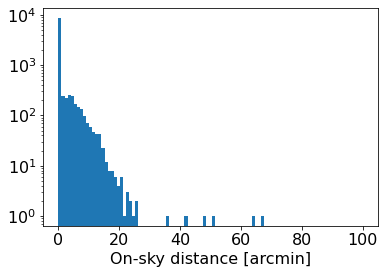

In [7]:
plt.figure()

nn_seps_arcmin = MaNGA_matched['DISTANCE_MANGA_SGA'].to('arcmin').value
nn_seps_bins = np.linspace(0, 100,100)
plt.hist(nn_seps_arcmin, bins=nn_seps_bins)

plt.yscale('log')

plt.xlabel('On-sky distance [arcmin]');

In [23]:
MaNGA_matched.sort('DISTANCE_MANGA_SGA')

idx_bool = np.logical_and(MaNGA_matched['DISTANCE_MANGA_SGA'] > 0.1*u.arcmin, 
                          MaNGA_matched['DISTANCE_MANGA_SGA'] < 0.2*u.arcmin)

MaNGA_matched[idx_bool]['plateifu', 'GALAXY', 'DISTANCE_MANGA_SGA', 'RA', 'DEC'].show_in_notebook()

idx,plateifu,GALAXY,DISTANCE_MANGA_SGA,RA,DEC
,,,deg,,
0,8245-6101,PGC1636229,0.0016972654751243538,136.74777392673872,20.800956831294435
1,11838-6101,PGC3281406,0.0017044151488303182,154.89256956608932,-1.0093475528756848
2,12621-12702,PGC048138,0.0017098575623473824,204.4087572414529,28.802633457227145
3,8996-12703,PGC2429296,0.0017573756925985122,171.9809486467894,53.00189804397847
4,12483-9102,NGC4395,0.001773103884603564,186.45599327561837,33.54629381436039
5,12081-3702,PGC1158976,0.001785938394629667,31.264817976847024,0.1751573335843551
6,8086-12702,UGC02832,0.0018879095907785581,55.55209472488834,-0.3543088149628119
7,10221-1901,NGC2536,0.0019599448121038364,122.81641197091547,25.17947725949435
8,8943-12704,PGC2073723,0.001968986109719165,156.43515139796298,36.02292424894447


In [9]:
#This calculation checks how much of the data would be kept for a cut at 0.02 arcmin at the first bin
1 - np.sum(nn_seps_arcmin > 0.04) / len(nn_seps_arcmin)

0.7408853011620686

## Eliminate Incorrect Matches
We now want to check to see if any of the MaNGA targets were incorrectly matched with an SGA galaxy. To do this, we can look at the matches with the largest separations and determine the largest separation distance at which the matches remain accurate. All matches about this distance need to be cut.

The check uses visual comparisons of the SDSS, Legacy Survey, and Marvin. 

The matches start to consistently allign when the separation (DISTANCE_MANGA_SGA) becomes ~~0.0026077$^\circ$~~ 0.002104$^\circ$.  Therefore, we will cut all galaxies before this and keep only the matches with separations $<$ ~~0.0025~~ 0.00215$^\circ$.

In [24]:
good_matches = MaNGA_matched['DISTANCE_MANGA_SGA'] < 0.00215*u.deg

In [25]:
MaNGA = MaNGA_matched[good_matches]
MaNGA.sort('DISTANCE_MANGA_SGA')
MaNGA[:5]

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7],IDX_SGA,DISTANCE_MANGA_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32

In [12]:
'''
for i in range(len(MaNGA)):
    MaNGA['plateifu'][i] = '{plate}-{IFU}'.format(plate=MaNGA['MaNGA_plate'][i], IFU=MaNGA['MaNGA_IFU'][i])

# MaNGA['plateifu'] = '{plate}-{IFU}'.format(plate=MaNGA['MaNGA_plate'], IFU=MaNGA['MaNGA_IFU'])

MaNGA
''';

#### Only save the MaNGA (plate, IFU), and SGA ID

In [26]:
MaNGA.write('MaNGA_SGA_crossmatch_2022-06-28.txt', 
            format='ascii.commented_header', 
            include_names=['plate', 'ifudsgn', 'plateifu', 'SGA_ID'], 
            overwrite=True)

Update Parameters (if needed) when changes occur with MaNGA

In [ ]:
new_parameters = Table.read('MaNGA_data_1.txt', format='ascii.commented_header')

len(new_parameters)

In [ ]:
updated_manga = join(new_parameters, MaNGA, keys='plateifu')

updated_manga

In [ ]:
updated_manga.write('MaNGA_SGA_data.txt', overwrite=True, format='ascii.commented_header')